# Sepsis-3 in MIMIC-III

This is the primary notebook for analyzing sepsis-3 in the MIMIC-III database. Before running this notebook, you'll need the `sepsis3-df.csv` file in the local directory: either by downloading it directly from PhysioNet or running the SQL scripts enclosed on the MIMIC-III database. See `sepsis-3-get-data.ipynb` for more detail.

In [1]:
from __future__ import print_function

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import subprocess
import tableone
from collections import OrderedDict
from statsmodels.formula.api import logit
from IPython.display import display, HTML # used to print out pretty pandas dataframes

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru
from sepsis_utils import venn

# venn diagram with matplotlib-venn
from matplotlib_venn import venn3

# used to calculate AUROC/accuracy
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

import colorsys
def gg_color_hue(n):
    hues = np.linspace(15, 375, n)
    hsv_tuples = [(x*1.0/360.0, 0.5, 0.8) for x in hues]
    rgb_tuples = map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples)
    return rgb_tuples


%matplotlib inline
plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
df = pd.read_csv('sepsis3-df.csv')

# add the composite outcome
df['composite_outcome'] = ( (df['hospital_expire_flag']==1) | (df['icu_los']>=3) ).astype(int)

labels = OrderedDict([['suspicion_poe', 'BC + ABX (Prescribed)']])

# add some other useful variables
df['blood culture'] = (~df['blood_culture_time'].isnull())
df['suspicion_poe'] = (~df['suspected_infection_time_poe_days'].isnull())

df['abx_poe'] = (~df['antibiotic_time_poe'].isnull())

df['sepsis-3'] = ((df['suspicion_poe']==1) & (df['sofa']>=2)).astype(int)
df['sofa>=2'] = (df['sofa']>=2).astype(int)


for c in ['intime','outtime',
          'suspected_infection_time_mv','suspected_infection_time',
          'suspected_infection_time_poe', 'blood_culture_time']:
    if c in df.columns:
        if df[c].dtype == 'object':
            df[c] = pd.to_datetime(df[c])

# list of the sepsis definitions
sepsis_list = ['sepsis_angus','sepsis_martin', 'sepsis_explicit',
               'sepsis_cdc','sepsis_nqf',
               'sepsis-3']

# Results for Abstract

In [3]:
# see get-data for the exclusions
reload(su)
print('{:5g} patients.'.format(df.shape[0]))

print('{:5g} ({:2.0f}%) suspected of infection.'.format(
        df['suspicion_poe'].sum(), df['suspicion_poe'].sum()*100.0/df.shape[0]))

print('{:5g} ({:2.2f}%) have SOFA >= 2.'.format(
    df['sofa>=2'].sum(),100.0*df['sofa>=2'].mean()))

print('{:5g} ({:2.2f}%) have Sepsis-3 criteria (intersection of above two).'.format(
    df['sepsis-3'].sum(),100.0*df['sepsis-3'].mean()))

print('{:5g} ({:2.2f}%) have suspicion and SOFA < 2.'.format(
        ((df['sofa>=2']==0) & (df['suspicion_poe']==1)).sum(),
        ((df['sofa>=2']==0) & (df['suspicion_poe']==1)).sum()*100.0/df.shape[0]))

for c in sepsis_list:
    print('{:5g} ({:3.2f}%) - {}'.format(
        df[c].sum(), df[c].sum()*100.0/df.shape[0], c))

print('{:5g} ({:2.2f}%) have Sepsis-3 criteria but not Angus.'.format(
        ((df['sepsis_angus']==0) & (df['sepsis-3']==1)).sum(),
        ((df['sepsis_angus']==0) & (df['sepsis-3']==1)).sum()*100.0/df.shape[0]))


np.random.seed(21381)
# cronbach alpha for construct validity
reload(su)
print('\n === Cronbach Alpha ===')
su.cronbach_alpha_table(df, sepsis_list)

# correlation coefficients
# TODO: tetrachoric correlation coefficient
print('\n === Correlation Coefficient ===')
su.corrcoef_table(df, sepsis_list, corr_type='tetrachoric')

11791 patients.
 7061 (60%) suspected of infection.
 8869 (75.22%) have SOFA >= 2.
 5784 (49.05%) have Sepsis-3 criteria (intersection of above two).
 1277 (10.83%) have suspicion and SOFA < 2.
 3368 (28.56%) - sepsis_angus
 1734 (14.71%) - sepsis_martin
 1062 (9.01%) - sepsis_explicit
 3761 (31.90%) - sepsis_cdc
 1302 (11.04%) - sepsis_nqf
 5784 (49.05%) - sepsis-3
 2917 (24.74%) have Sepsis-3 criteria but not Angus.

 === Cronbach Alpha ===
          	martin    	explicit  	cdc       	nqf       	sepsis-3  	
angus     	0.69 [0.68-0.70] 0.62 [0.61-0.63] 0.62 [0.60-0.63] 0.63 [0.62-0.65] 0.62 [0.61-0.64] 
martin    	          	0.85 [0.84-0.85] 0.54 [0.52-0.55] 0.91 [0.90-0.92] 0.49 [0.48-0.50] 
explicit  	          	          	0.49 [0.48-0.51] 0.89 [0.89-0.90] 0.40 [0.39-0.41] 
cdc       	          	          	          	0.53 [0.52-0.55] 0.76 [0.75-0.76] 
nqf       	          	          	          	          	0.45 [0.43-0.46] 
sepsis-3  	          	          	          	          	      

# Results section

We now print out the results in the same order as they are in the paper.

# Demographics

In [4]:
# Call the print_demographics subfunction, which prints out a reasonably formatted table
reload(su)
su.print_demographics(df)

print('\nAlive vs. dead')
su.print_demographics(df, idx=(df.hospital_expire_flag.values==1))

print('')

print('{:5g} have SIRS >= 2 ({:2.2f}%) on admission.'.format(
    (df.sirs.values >= 2).sum(),100.0*(df.sirs.values >= 2).mean()))

print('{:5g} have qSOFA >= 2 ({:2.2f}%) on admission.'.format(
    (df.qsofa.values >= 2).sum(),100.0*(df.qsofa.values >= 2).mean()))

print('{:5g} have SOFA >= 2 ({:2.2f}%).'.format(
    (df.sofa.values >= 2).sum(),100.0*(df.sofa.values >= 2).mean()))

print('{:5g} have LODS >= 2 ({:2.2f}%).'.format(
    (df.lods.values >= 2).sum(),100.0*(df.lods.values >= 2).mean()))

N                   	11791
age                 	64.5 [51.1, 78.5]
gender              	6478 (54.9%)
bmi                 	28.7 +- 8.4
Race                	
White               	8497 (72.1%)
Black               	1110 (9.4%)
Hispanic            	 457 (9.4%)
elixhauser_hospital 	1.0 [-1.0, 6.0]
qsofa               	2.0 [1.0, 2.0]
sirs                	3.0 [2.0, 3.0]
sofa                	3.0 [2.0, 5.0]
mlods               
lactate_max         
vent                	4149 (35.2%)
icu_los             	1.9 [1.1, 3.5]
hosp_los            	5.6 [3.1, 9.6]
thirtyday_expire_flag	1619 (13.7%)
hospital_expire_flag	1277 (10.8%)

Alive vs. dead
N                   	10514     	1277     	     
age                 	63.3 [50.0, 77.5]	74.9 [61.8, 83.7]	< 0.001
gender              	5795 (55.1%)	 683 (53.5%)	0.281
bmi                 	28.7 +- 8.2	28.1 +- 10.1	0.167
ethnicity           	          	          	< 0.001
  black             	1036 (9.9%)	  74 (5.8%)	     
  hispanic          	 424 (4.0%)	  33 (2.6%)	  

In [5]:
# list probability of outcome for each score
scores = ['suspicion_poe','sofa>=2',
          'sepsis-3',
          'sepsis_angus','sepsis_martin','sepsis_explicit',
          'sepsis_cdc','sepsis_nqf']

scores_dict = {
    'suspicion_poe': 'Suspected infection',
    'sofa>=2': 'SOFA >= 2',
    'sepsis-3': 'Sepsis-3',
    'sepsis_angus': 'Angus et al. criteria',
    'sepsis_martin': 'Martin et al. criteria',
    'sepsis_explicit': 'Explicit',
    'sepsis_cdc': 'CDC',
    'sepsis_nqf': 'CMS'
}
target_header = "hospital_expire_flag"
idx = df[target_header]==1

print()
print('=== {} ==='.format(target_header))
print()
print('{:15s}\t{:8s}\t{:5s}\t{:5s}'.format(
    'Criteria','N','p(death|c)', 'p(death|~c)'))
for c in scores:
    print('{:15s}\t{:4d}, {:2.1f}%\t{:2.1f}%\t\t{:2.1f}%'.format(
            c,
            np.sum( df[c]==1 ),
            np.sum( df[c]==1 )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idx )*100.0 / np.sum( df[c]!=1 )
        ))
    
target_header = "composite_outcome"
idx = df[target_header]==1

print()
print('=== {} ==='.format(target_header))
print()

print('{:15s}\t{:8s}\t{:5s}\t{:5s}'.format(
    'Criteria','N','p(death|c)', 'p(death|~c)'))
for c in scores:
    print('{:15s}\t{:4d}, {:2.1f}%\t{:2.1f}%\t\t{:2.1f}%'.format(
            c,
            np.sum( df[c]==1 ),
            np.sum( df[c]==1 )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idx )*100.0 / np.sum( df[c]!=1 )
        ))


=== hospital_expire_flag ===

Criteria       	N       	p(death|c)	p(death|~c)
suspicion_poe  	7061, 59.9%	12.5%		8.3%
sofa>=2        	8869, 75.2%	13.2%		3.6%
sepsis-3       	5784, 49.1%	14.5%		7.3%
sepsis_angus   	3368, 28.6%	17.9%		8.0%
sepsis_martin  	1734, 14.7%	22.7%		8.8%
sepsis_explicit	1062, 9.0%	30.1%		8.9%
sepsis_cdc     	3761, 31.9%	18.6%		7.2%
sepsis_nqf     	1302, 11.0%	27.2%		8.8%

=== composite_outcome ===

Criteria       	N       	p(death|c)	p(death|~c)
suspicion_poe  	7061, 59.9%	46.3%		19.9%
sofa>=2        	8869, 75.2%	41.2%		19.2%
sepsis-3       	5784, 49.1%	50.0%		21.9%
sepsis_angus   	3368, 28.6%	61.2%		25.5%
sepsis_martin  	1734, 14.7%	60.1%		31.5%
sepsis_explicit	1062, 9.0%	70.7%		32.2%
sepsis_cdc     	3761, 31.9%	61.1%		23.8%
sepsis_nqf     	1302, 11.0%	64.7%		32.1%


/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'DejaVu Sans'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


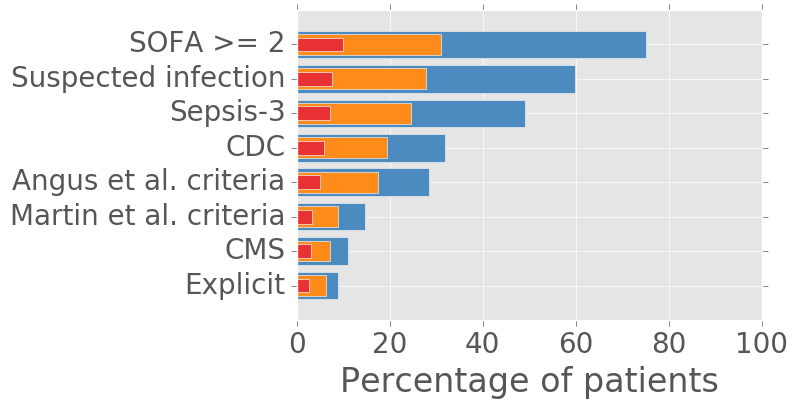


Criteria       	N       	p(death|c)	p(death|~c)	p(comp|c)	p(comp|~c)
sofa>=2        	8869, 75.2%	13.2%		3.6%		41.2%		19.2%
suspicion_poe  	7061, 59.9%	12.5%		8.3%		46.3%		19.9%
sepsis-3       	5784, 49.1%	14.5%		7.3%		50.0%		21.9%
sepsis_cdc     	3761, 31.9%	18.6%		7.2%		61.1%		23.8%
sepsis_angus   	3368, 28.6%	17.9%		8.0%		61.2%		25.5%
sepsis_martin  	1734, 14.7%	22.7%		8.8%		60.1%		31.5%
sepsis_nqf     	1302, 11.0%	27.2%		8.8%		64.7%		32.1%
sepsis_explicit	1062, 9.0%	30.1%		8.9%		70.7%		32.2%

Criteria,N,p(death|c),p(death|~c),p(comp|c),p(comp|~c)
SOFA >= 2,8869 75.2%,13.2%,3.6%,41.2%,19.2%
Suspected infection,7061 59.9%,12.5%,8.3%,46.3%,19.9%
Sepsis-3,5784 49.1%,14.5%,7.3%,50.0%,21.9%
CDC,3761 31.9%,18.6%,7.2%,61.1%,23.8%
Angus et al. criteria,3368 28.6%,17.9%,8.0%,61.2%,25.5%
Martin et al. criteria,1734 14.7%,22.7%,8.8%,60.1%,31.5%
CMS,1302 11.0%,27.2%,8.8%,64.7%,32.1%
Explicit,1062 9.0%,30.1%,8.9%,70.7%,32.2%


In [6]:

# print the frequencies
# list probability of outcome for each score
scores = ['suspicion_poe','sofa>=2',
          'sepsis-3',
          'sepsis_angus','sepsis_martin','sepsis_explicit',
          'sepsis_cdc','sepsis_nqf']

scores_dict = {
    'suspicion_poe': 'Suspected infection',
    'sofa>=2': 'SOFA >= 2',
    'sepsis-3': 'Sepsis-3',
    'sepsis_angus': 'Angus et al. criteria',
    'sepsis_martin': 'Martin et al. criteria',
    'sepsis_explicit': 'Explicit',
    'sepsis_cdc': 'CDC',
    'sepsis_nqf': 'CMS'
}

idx = df['hospital_expire_flag']==1
idxComp = df['composite_outcome']==1

score_plot = np.zeros( [len(scores), 3] )
for i, c in enumerate(scores):
    # proportion of patients
    score_plot[i, 0] = np.sum( df[c]==1 )*100.0/df.shape[0]
    
    # with mort
    score_plot[i, 1] = np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 )
    # with comp
    score_plot[i, 2] = np.sum( (df[c]==1)&idxComp )*100.0 / np.sum( df[c]==1 )
    
S = len(scores)

idxSort = np.argsort(score_plot[:,0])
plt.figure()
plt.barh( range(S), score_plot[idxSort,0], color=col[1], align='center')
plt.barh( range(S), score_plot[idxSort,0]*score_plot[idxSort,2]/100.0, color=col[3], align='center', height=0.6)
plt.barh( range(S), score_plot[idxSort,0]*score_plot[idxSort,1]/100.0, color=col[0], align='center', height=0.4)

plt.yticks(range(S), [scores_dict[scores[x]] for x in idxSort])
plt.xlabel('Percentage of patients')
plt.xlim([0,100])
plt.show()

print('')
print('{:15s}\t{:8s}\t{:5s}\t{:5s}\t{:5s}\t{:5s}'.format(
    'Criteria','N','p(death|c)', 'p(death|~c)', 'p(comp|c)', 'p(comp|~c)'))
for i in idxSort[-1::-1]:
    c=scores[i]
    print('{:15s}\t{:4d}, {:2.1f}%\t{:2.1f}%\t\t{:2.1f}%\t\t{:2.1f}%\t\t{:2.1f}%'.format(
            c,
            np.sum( df[c]==1 ),
            np.sum( df[c]==1 )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idx )*100.0 / np.sum( df[c]!=1 ),
            np.sum( (df[c]==1)&idxComp )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idxComp )*100.0 / np.sum( df[c]!=1 )
        ))
    

print('')
print('{},{},{},{},{},{}'.format(
    'Criteria','N','p(death|c)', 'p(death|~c)', 'p(comp|c)', 'p(comp|~c)'))
# same print but to csv
for i in idxSort[-1::-1]:
    c=scores[i]
    print('{},{:4d} {:2.1f}%,{:2.1f}%,{:2.1f}%,{:2.1f}%,{:2.1f}%'.format(
            scores_dict[c],
            np.sum( df[c]==1 ),
            np.sum( df[c]==1 )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idx )*100.0 / np.sum( df[c]!=1 ),
            np.sum( (df[c]==1)&idxComp )*100.0 / np.sum( df[c]==1 ),
            np.sum( (df[c]!=1)&idxComp )*100.0 / np.sum( df[c]!=1 )
        ))

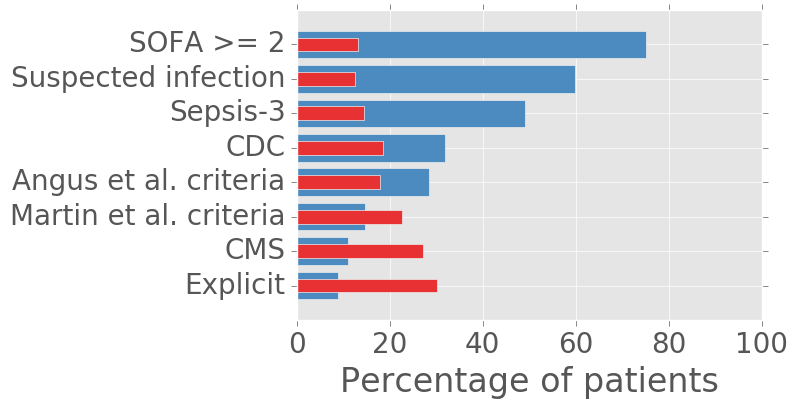

In [7]:

# print the frequencies
# list probability of outcome for each score
scores = ['suspicion_poe','sofa>=2',
          'sepsis-3',
          'sepsis_angus','sepsis_martin','sepsis_explicit',
          'sepsis_cdc','sepsis_nqf']

scores_dict = {
    'suspicion_poe': 'Suspected infection',
    'sofa>=2': 'SOFA >= 2',
    'sepsis-3': 'Sepsis-3',
    'sepsis_angus': 'Angus et al. criteria',
    'sepsis_martin': 'Martin et al. criteria',
    'sepsis_explicit': 'Explicit',
    'sepsis_cdc': 'CDC',
    'sepsis_nqf': 'CMS'
}

idx = df['hospital_expire_flag']==1
idxComp = df['composite_outcome']==1

score_plot = np.zeros( [len(scores), 3] )
for i, c in enumerate(scores):
    # proportion of patients
    score_plot[i, 0] = np.sum( df[c]==1 )*100.0/df.shape[0]
    
    # with mort
    score_plot[i, 1] = np.sum((df[c]==1)&idx)*100.0 / np.sum( df[c]==1 )
    # with comp
    score_plot[i, 2] = np.sum( (df[c]==1)&idxComp )*100.0 / np.sum( df[c]==1 )
    
S = len(scores)

idxSort = np.argsort(score_plot[:,0])

plt.figure()
plt.barh( range(S), score_plot[idxSort,0], color=col[1], align='center', label='Patients')
#plt.barh( range(S), score_plot[idxSort,2], color=col[3], align='center', height=0.6)
plt.barh( range(S), score_plot[idxSort,1], color=col[0], align='center', height=0.4, label='Patients who died')
#ax2.set_xlim(ax2.get_xlim()[::-1])

#plt.plot( score_plot[idxSort,1], range(S), color=col[0], marker='o', markersize=10)
#ax1.barh( range(S), score_plot[idxSort,0]*score_plot[idxSort,2]/100.0, color=col[3], align='center', height=0.6)
#
#ax2 = ax1.twiny()
#ax2.barh( range(S), (score_plot[idxSort,0]*score_plot[idxSort,1]/100.0), color=col[0], align='center', height=0.4)
#ax2.set_xlim(ax2.get_xlim()[::-1])
#ax2.plot(range(S), score_plot[idxSort,0]*score_plot[idxSort,1]/100.0, color=col[0] )

plt.yticks(range(S), [scores_dict[scores[x]] for x in idxSort])
plt.xlabel('Percentage of patients')
#plt.legend(loc='lower right')
plt.xlim([0,100])
plt.show()

In [8]:
# note: we need to subselect to the cohort suspected of infection in order to compare AUROCs to previous literature
idx = df['suspicion_poe'].values == 1
pred_header = 'sofa'

np.random.seed(7891)
# AUROC of sofa for in-hospital mortality
target_header = 'hospital_expire_flag'
auc, ci = ru.calc_auc(df.loc[idx, pred_header].values, df.loc[idx, target_header].values, with_ci=True)
print('{} - univariable against {}'.format(pred_header,target_header))
print('AUROC = {:0.3f} [{:0.2f} - {:0.2f}]'.format(auc, ci[0], ci[1]))

# composite outcome
target_header = 'composite_outcome'
auc, ci = ru.calc_auc(df.loc[idx, pred_header].values, df.loc[idx, target_header].values, with_ci=True)
print('{} - univariable against {}'.format(pred_header,target_header))
print('AUROC = {:0.3f} [{:0.2f} - {:0.2f}]'.format(auc, ci[0], ci[1]))

sofa - univariable against hospital_expire_flag
AUROC = 0.740 [0.72 - 0.76]
sofa - univariable against composite_outcome
AUROC = 0.688 [0.68 - 0.70]


In [9]:
# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_dict = OrderedDict([['SOFA>=2', df['sofa>=2']]
                        ])
stats_all = su.get_op_stats(yhat_dict, df[target_header].values)

su.print_op_stats(stats_all)

Metric

     	SOFA>=2 
TN   	 2361
FP   	 5219
FN   	  561
TP   	 3650
Sens 	87 [86, 88]
Spec 	31 [30, 32]
PPV  	41 [40, 42]
NPV  	81 [79, 82]
F1   	 55.81   
NTP  	 30.96   
NFP  	 44.26   


# Sepsis

Create the sepsis-3 criteria: SOFA >= 2 and suspicion of infection.

In [10]:
print('{:5g} ({:3.2f}%)  first ICU stay for adults.'.format(
        df['icustay_id'].count(), 100))
print('{:5g} ({:3.2f}%)  suspected of infection'.format(
        np.sum(df['suspicion_poe']),
        np.sum(df['suspicion_poe'])*100.0/df.shape[0]))
print('{:5g} ({:3.2f}%)  with a positive blood culture'.format(
    df['blood_culture_positive'].sum(), df['blood_culture_positive'].sum()*100.0/df.shape[0]))

print()
for i, c in enumerate(labels):
    print('{:5g} ({:3.2f}%) - {}'.format(
        df[c].sum(), df[c].sum()*100.0/df.shape[0], c))

11791 (100.00%)  first ICU stay for adults.
 7061 (59.88%)  suspected of infection
 2803 (23.77%)  with a positive blood culture

 7061 (59.88%) - suspicion_poe


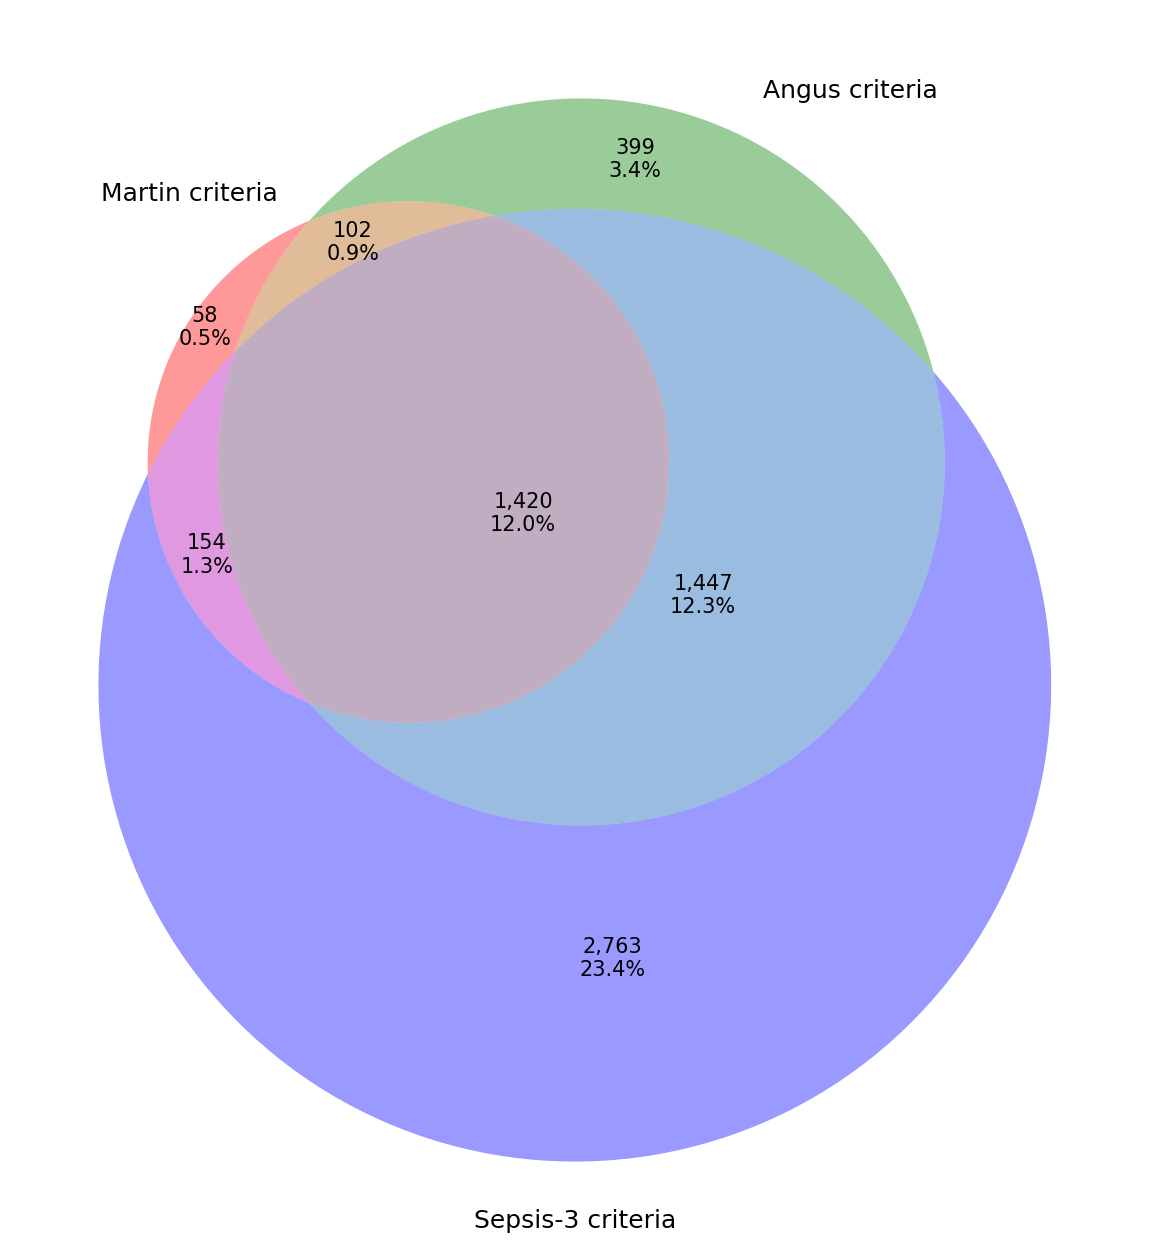

1420 patients (12.0%) satisfied all criteria.
5448 patients (46.2%) satisfied no criteria.
12.9% (1522) - sepsis_angus & sepsis_martin
13.3% (1574) - sepsis-3 & sepsis_martin
24.3% (2867) - sepsis-3 & sepsis_angus


In [11]:
# venn diagram with matplotlib-venn
from matplotlib_venn import venn3

venn_labels = OrderedDict([
        ['sepsis_martin', 'Martin criteria'],
        ['sepsis_angus', 'Angus criteria'],
        ['sepsis-3', 'Sepsis-3 criteria']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

set_other = set(df['icustay_id'].values).difference(*sets)

plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-sepsis3-angus-martin.png')
plt.show()

set_other = set(df['icustay_id'].values).difference(*sets)
# Other numbers for above venn diagram
print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set_other),
        len(set_other)*100.0 / df.shape[0]))

# pair-wise counts
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

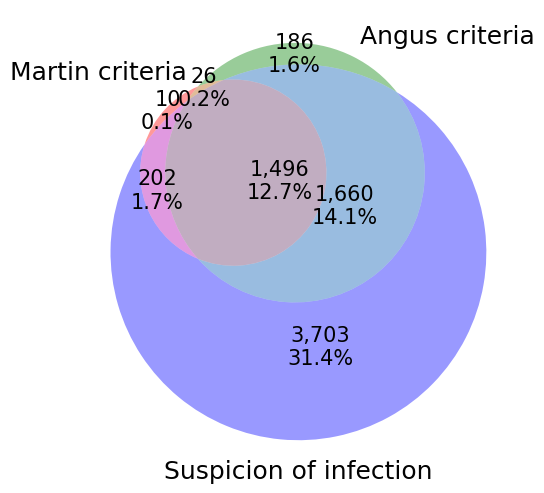

1496 patients (12.7%) satisfied all criteria.
4508 patients (38.2%) satisfied no criteria.
12.9% (1522) - sepsis_angus & sepsis_martin
14.4% (1698) - suspicion_poe & sepsis_martin
26.8% (3156) - suspicion_poe & sepsis_angus


In [12]:
venn_labels = OrderedDict([
        ['sepsis_martin', 'Martin criteria'],
        ['sepsis_angus', 'Angus criteria'],
        ['suspicion_poe', 'Suspicion of infection']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

set_other = set(df['icustay_id'].values).difference(*sets)

plt.figure(figsize=[6,6])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-blood-culture.png')
plt.show()

set_other = set(df['icustay_id'].values).difference(*sets)
# Other numbers for above venn diagram
print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set_other),
        len(set_other)*100.0 / df.shape[0]))

# Angus & sepsis-3
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

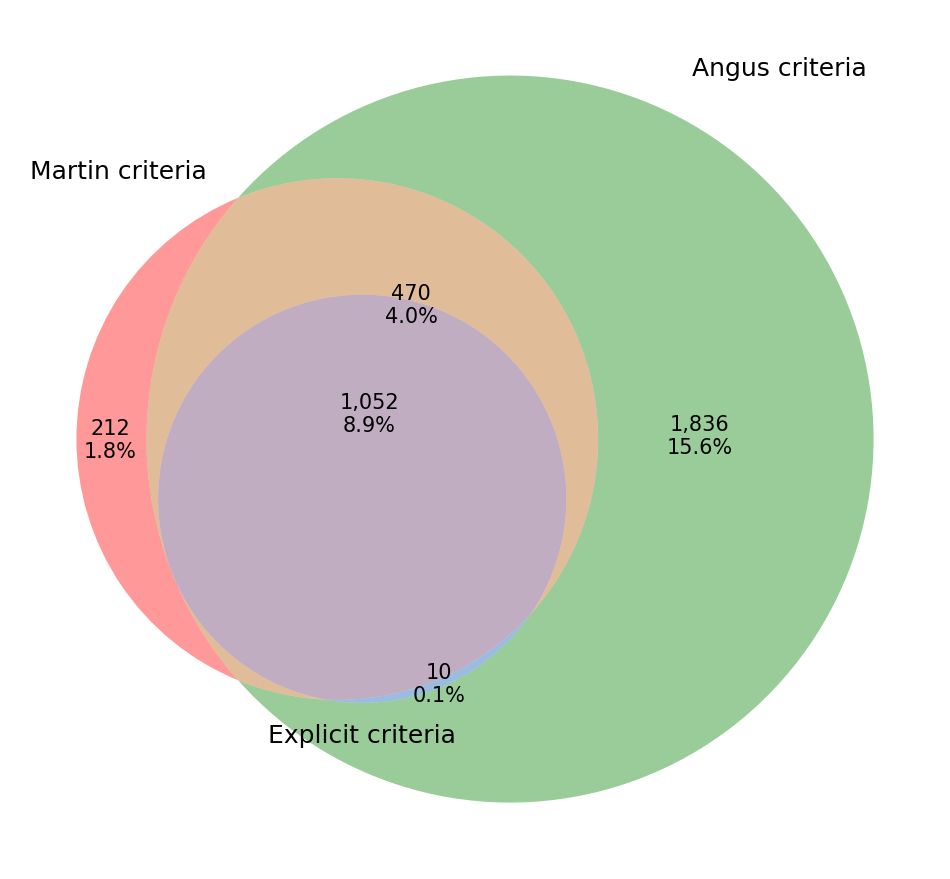

3580 patients (30.4%) satisfied any criteria.
1052 patients (8.9%) satisfied all criteria.
8211 patients (69.6%) satisfied no criteria.
12.9% (1522) - sepsis_angus & sepsis_martin
8.9% (1052) - sepsis_explicit & sepsis_martin
9.0% (1062) - sepsis_explicit & sepsis_angus


In [13]:
venn_labels = OrderedDict([
        ['sepsis_martin', 'Martin criteria'],
        ['sepsis_angus', 'Angus criteria'],
        ['sepsis_explicit', 'Explicit criteria']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

set_other = set(df['icustay_id'].values).difference(*sets)

plt.figure(figsize=[12,12])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-blood-culture.png')
plt.show()

set_other = set(df['icustay_id'].values).difference(*sets)
# Other numbers for above venn diagram
print('{} patients ({:2.1f}%) satisfied any criteria.'.format(
    df.shape[0]-len(set_other),
    (df.shape[0]-len(set_other))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set_other),
        len(set_other)*100.0 / df.shape[0]))

# Angus & sepsis-3
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

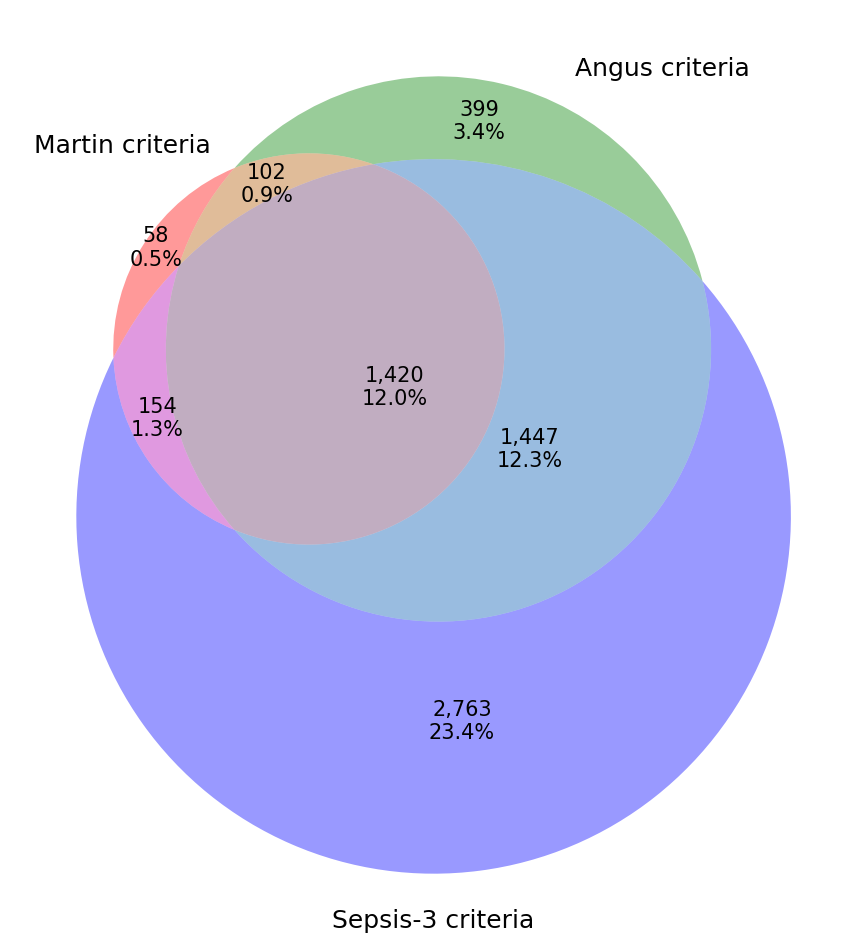

6343 patients (53.8%) satisfied any criteria.
1420 patients (12.0%) satisfied all criteria.
5448 patients (46.2%) satisfied no criteria.
12.9% (1522) - sepsis_angus & sepsis_martin
13.3% (1574) - sepsis-3 & sepsis_martin
24.3% (2867) - sepsis-3 & sepsis_angus


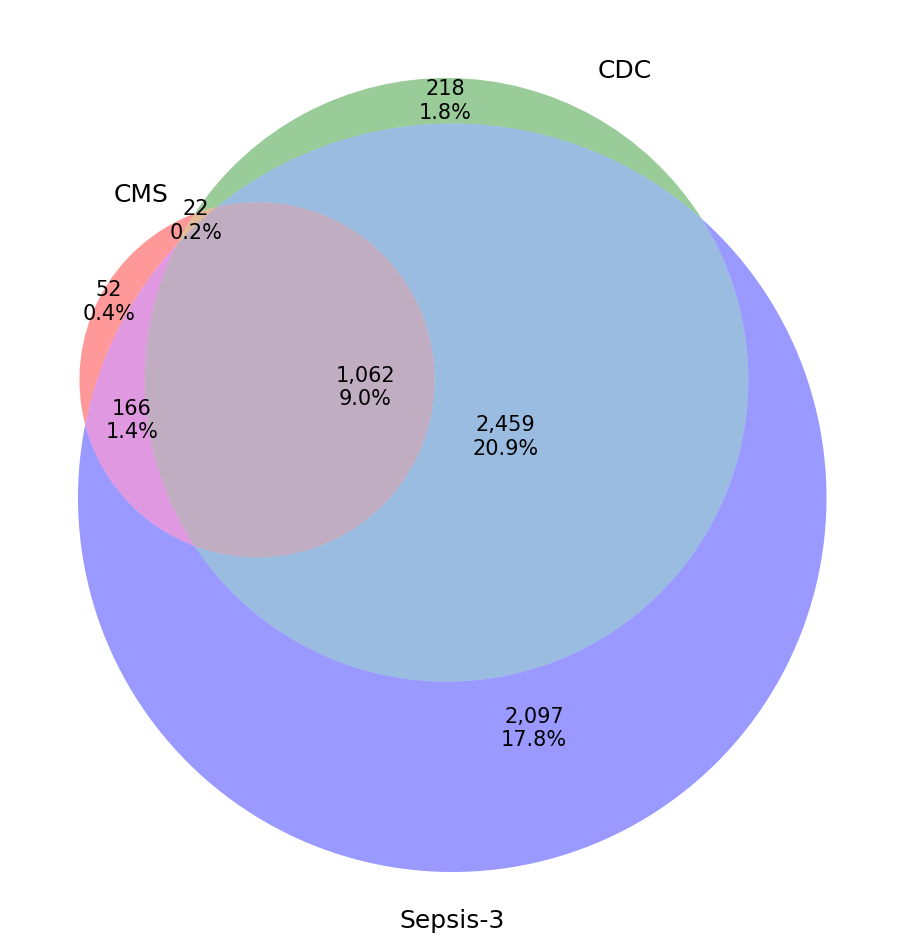

6076 patients (51.5%) satisfied any criteria.
1062 patients (9.0%) satisfied all criteria.
5715 patients (48.5%) satisfied no criteria.
9.2% (1084) - sepsis_cdc & sepsis_nqf
10.4% (1228) - sepsis-3 & sepsis_nqf
29.9% (3521) - sepsis-3 & sepsis_cdc


In [14]:
##### venn diagram with matplotlib-venn
from matplotlib_venn import venn3

venn_labels = OrderedDict([
        ['sepsis_martin', 'Martin criteria'],
        ['sepsis_angus', 'Angus criteria'],
        ['sepsis-3', 'Sepsis-3 criteria']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

set_other = set(df['icustay_id'].values).difference(*sets)

plt.figure(figsize=[12,12])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-sepsis3-angus-martin.png')
plt.show()

set_other = set(df['icustay_id'].values).difference(*sets)
# Other numbers for above venn diagram
print('{} patients ({:2.1f}%) satisfied any criteria.'.format(
    df.shape[0]-len(set_other),
    (df.shape[0]-len(set_other))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set_other),
        len(set_other)*100.0 / df.shape[0]))

# pair-wise counts
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))
            
# print the frequencies

venn_labels = OrderedDict([
        ['sepsis_nqf', 'CMS'],
        ['sepsis_cdc', 'CDC'],
        ['sepsis-3', 'Sepsis-3']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

set_other = set(df['icustay_id'].values).difference(*sets)

plt.figure(figsize=[12,12])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-blood-culture.png')
plt.show()

set_other = set(df['icustay_id'].values).difference(*sets)
# Other numbers for above venn diagram
print('{} patients ({:2.1f}%) satisfied any criteria.'.format(
    df.shape[0]-len(set_other),
    (df.shape[0]-len(set_other))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set_other),
        len(set_other)*100.0 / df.shape[0]))

# Angus & sepsis-3
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

In [15]:
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        set_both = set.difference(sets[i],sets[j])
        print('{:01.2f}%\t({:5d}) - in {} but not {}'.format(
                len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

0.00%	(    0) - in sepsis_nqf but not sepsis_nqf
1.85%	(  218) - in sepsis_nqf but not sepsis_cdc
0.63%	(   74) - in sepsis_nqf but not sepsis-3
22.70%	( 2677) - in sepsis_cdc but not sepsis_nqf
0.00%	(    0) - in sepsis_cdc but not sepsis_cdc
2.04%	(  240) - in sepsis_cdc but not sepsis-3
38.64%	( 4556) - in sepsis-3 but not sepsis_nqf
19.19%	( 2263) - in sepsis-3 but not sepsis_cdc
0.00%	(    0) - in sepsis-3 but not sepsis-3


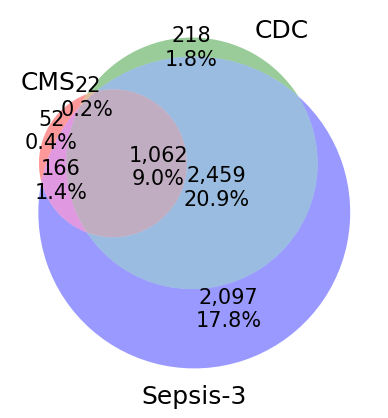

100.00%	( 1302) - overlap of sepsis_nqf and sepsis_nqf over sepsis_nqf
83.26%	( 1084) - overlap of sepsis_nqf and sepsis_cdc over sepsis_nqf
94.32%	( 1228) - overlap of sepsis_nqf and sepsis-3 over sepsis_nqf
28.82%	( 1084) - overlap of sepsis_cdc and sepsis_nqf over sepsis_cdc
100.00%	( 3761) - overlap of sepsis_cdc and sepsis_cdc over sepsis_cdc
93.62%	( 3521) - overlap of sepsis_cdc and sepsis-3 over sepsis_cdc
21.23%	( 1228) - overlap of sepsis-3 and sepsis_nqf over sepsis-3
60.87%	( 3521) - overlap of sepsis-3 and sepsis_cdc over sepsis-3
100.00%	( 5784) - overlap of sepsis-3 and sepsis-3 over sepsis-3


In [16]:

plt.figure(figsize=[5,5])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-blood-culture.png')
plt.show()

for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        set_both = set.difference(sets[i],sets[j])
        print('{:01.2f}%\t({:5d}) - overlap of {} and {} over {}'.format(
                (len(sets[i]) - len(set_both))*100.0 / len(sets[i]), len(sets[i]) - len(set_both), c1, c2, c1))

In [17]:
(2459+1062.0) / (2459.0+1062+218+22)

0.9361871842595054

In [18]:
venn_labels

OrderedDict([('sepsis_nqf', 'CMS'),
             ('sepsis_cdc', 'CDC'),
             ('sepsis-3', 'Sepsis-3')])

In [19]:
4556.0 / (4556.0 + len(sets[0]))

0.7777398429498122

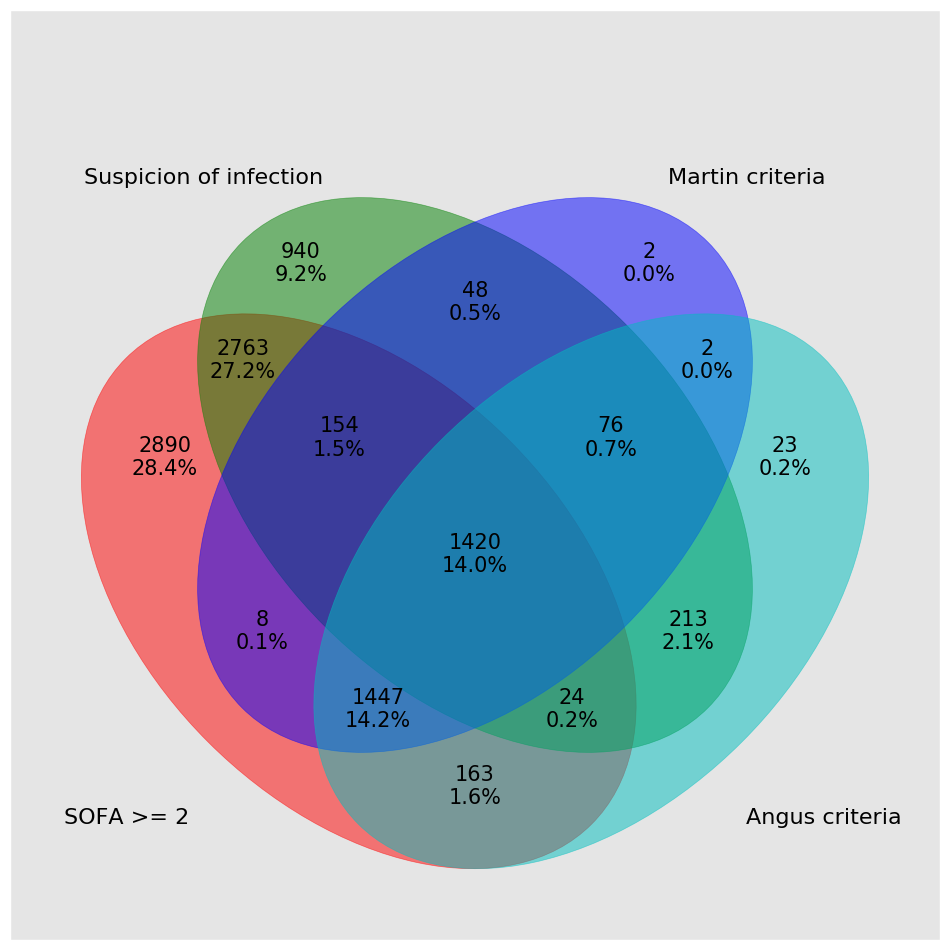

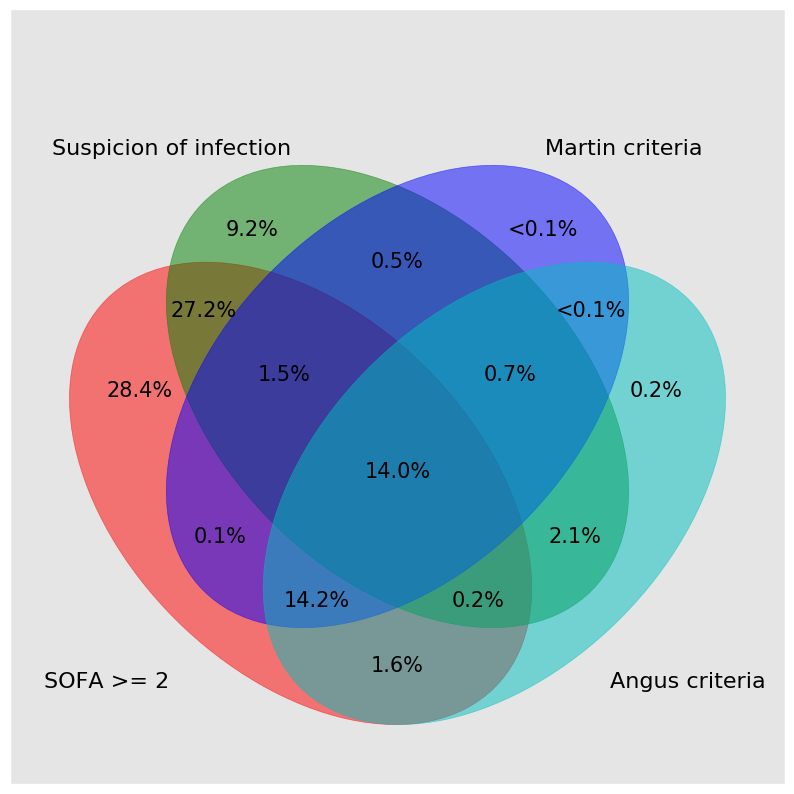

1420 patients (12.0%) satisfied all criteria.
1618 patients (13.7%) satisfied no criteria.
25.9% (3054) - sepsis_angus & sofa>=2
49.1% (5784) - suspicion_poe & sofa>=2
26.8% (3156) - suspicion_poe & sepsis_angus
13.6% (1606) - sepsis_martin & sofa>=2
12.9% (1522) - sepsis_martin & sepsis_angus
14.4% (1698) - sepsis_martin & suspicion_poe


In [20]:
reload(venn)

venn_labels = OrderedDict([
        ['sofa>=2', 'SOFA >= 2'],
        ['sepsis_angus', 'Angus criteria'],
        ['suspicion_poe', 'Suspicion of infection'],
        ['sepsis_martin', 'Martin criteria']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

fontdict = {'fontsize': 15, 'fontweight': 'normal'}
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent', figsize=[12,12])
leg = plt.legend('off')
leg.remove()
plt.show()

# also with just percent
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent_only')
leg = plt.legend('off')
leg.remove()
plt.show()

print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set(df['icustay_id'].values).difference(set.union(*sets))),
        len(set(df['icustay_id'].values).difference(set.union(*sets)))*100.0 / df.shape[0]))

# Angus & sepsis-3
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

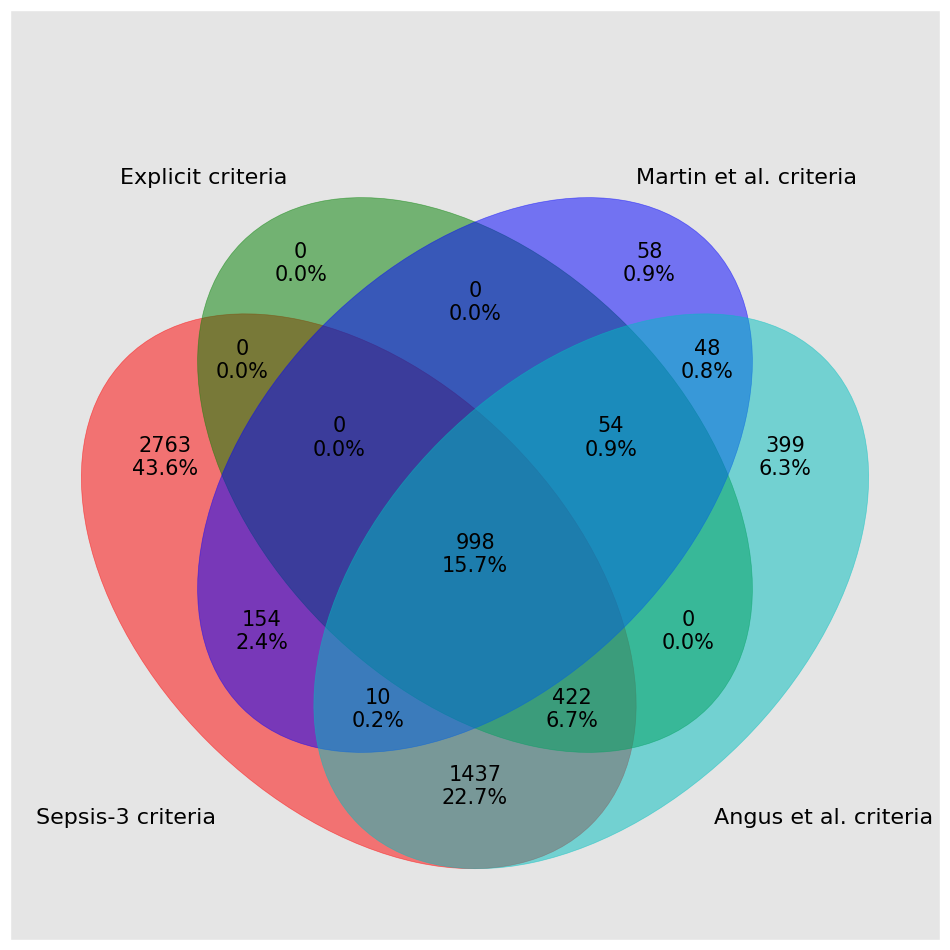

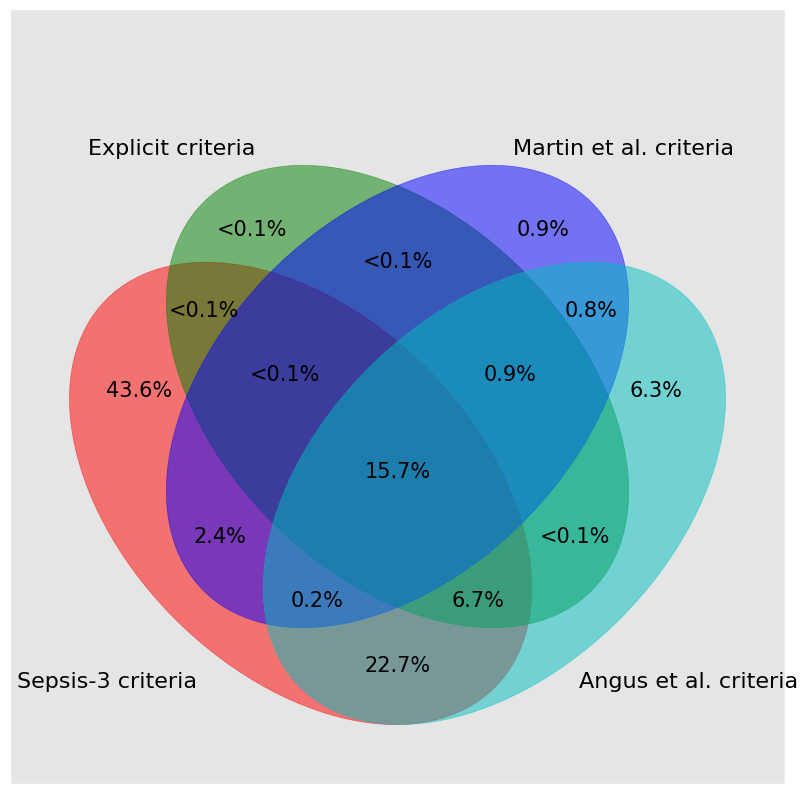

998 patients (8.5%) satisfied all criteria.
5448 patients (46.2%) satisfied no criteria.
24.3% (2867) - sepsis_angus & sepsis-3
8.5% (1008) - sepsis_explicit & sepsis-3
9.0% (1062) - sepsis_explicit & sepsis_angus
13.3% (1574) - sepsis_martin & sepsis-3
12.9% (1522) - sepsis_martin & sepsis_angus
8.9% (1052) - sepsis_martin & sepsis_explicit


In [21]:
reload(venn)

venn_labels = OrderedDict([
        ['sepsis-3', 'Sepsis-3 criteria'],
        ['sepsis_angus', 'Angus et al. criteria'],
        ['sepsis_explicit', 'Explicit criteria'],
        ['sepsis_martin', 'Martin et al. criteria']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

fontdict = {'fontsize': 15, 'fontweight': 'normal'}
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent', figsize=[12,12])
leg = plt.legend('off')
leg.remove()
plt.show()

# also with just percent
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent_only')
leg = plt.legend('off')
leg.remove()
plt.show()

print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set(df['icustay_id'].values).difference(set.union(*sets))),
        len(set(df['icustay_id'].values).difference(set.union(*sets)))*100.0 / df.shape[0]))



# Angus & sepsis-3
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

# Venn with CDC/NQF

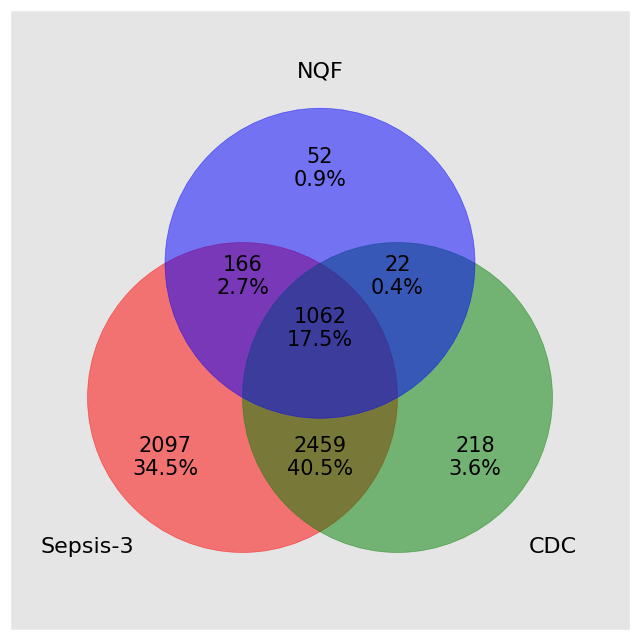

1062 patients (9.0%) satisfied all criteria.
5715 patients (48.5%) satisfied no criteria.
29.9% (3521) - sepsis_cdc & sepsis-3
10.4% (1228) - sepsis_nqf & sepsis-3
9.2% (1084) - sepsis_nqf & sepsis_cdc


In [22]:
reload(venn)

venn_labels = OrderedDict([
        ['sepsis-3', 'Sepsis-3'],
        ['sepsis_cdc', 'CDC'],
        ['sepsis_nqf', 'NQF']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

fontdict = {'fontsize': 15, 'fontweight': 'normal'}
venn.venn3(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent', figsize=[8,8])
leg = plt.legend('off')
leg.remove()
plt.show()

print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set(df['icustay_id'].values).difference(set.union(*sets))),
        len(set(df['icustay_id'].values).difference(set.union(*sets)))*100.0 / df.shape[0]))

# print out overlaps
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

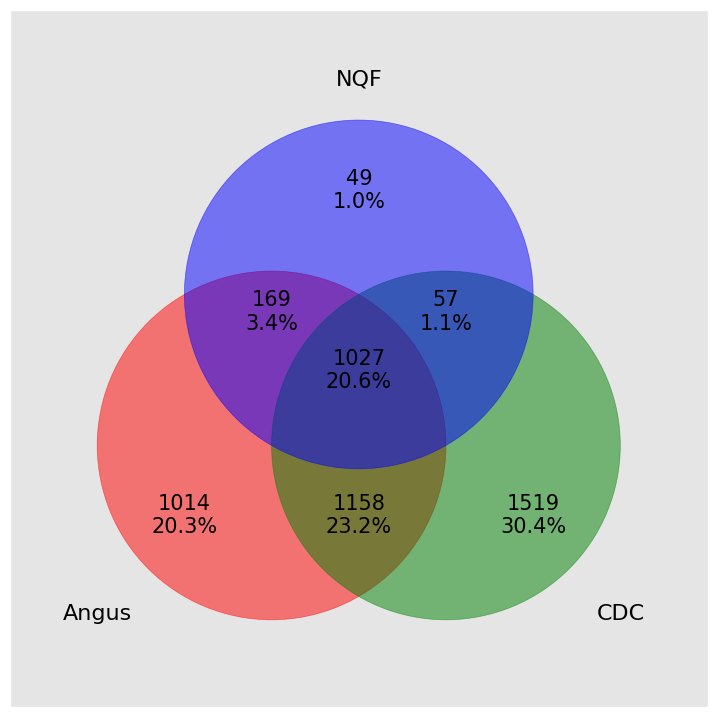

1027 patients (8.7%) satisfied all criteria.
6798 patients (57.7%) satisfied no criteria.
18.5% (2185) - sepsis_cdc & sepsis_angus
10.1% (1196) - sepsis_nqf & sepsis_angus
9.2% (1084) - sepsis_nqf & sepsis_cdc


In [23]:
reload(venn)

venn_labels = OrderedDict([
        ['sepsis_angus', 'Angus'],
        ['sepsis_cdc', 'CDC'],
        ['sepsis_nqf', 'NQF']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

fontdict = {'fontsize': 15, 'fontweight': 'normal'}
venn.venn3(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent', figsize=[9,9])
leg = plt.legend('off')
leg.remove()
plt.show()

print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set(df['icustay_id'].values).difference(set.union(*sets))),
        len(set(df['icustay_id'].values).difference(set.union(*sets)))*100.0 / df.shape[0]))

# print out overlaps
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

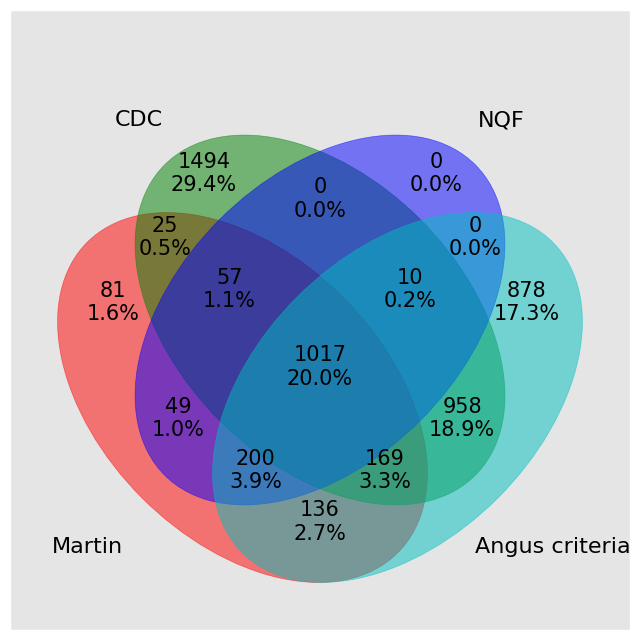

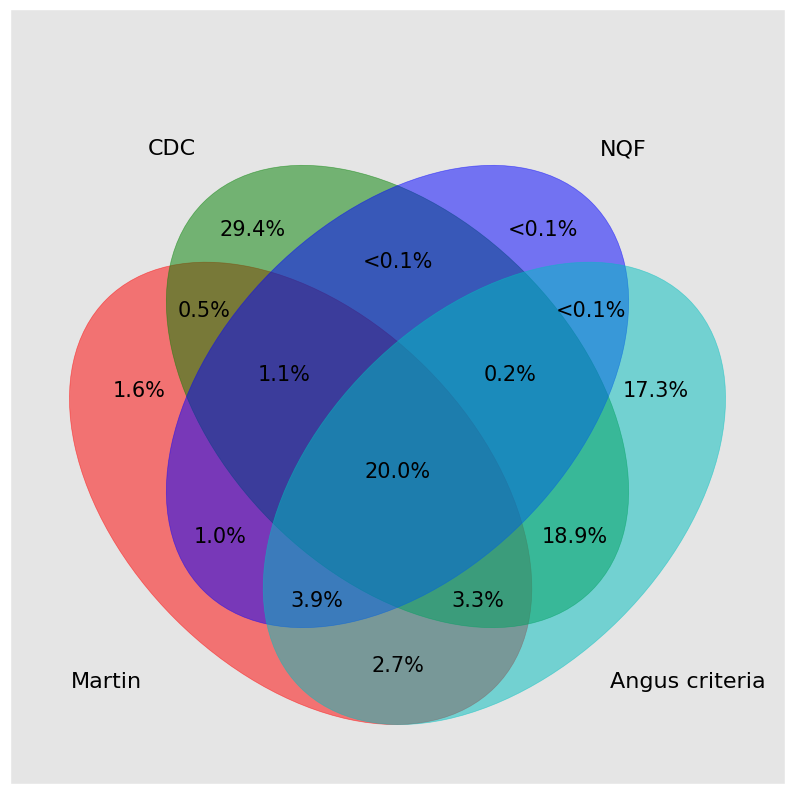

1017 patients (8.6%) satisfied all criteria.
6717 patients (57.0%) satisfied no criteria.
12.9% (1522) - sepsis_angus & sepsis_martin
11.0% (1299) - sepsis_cdc & sepsis_martin
18.5% (2185) - sepsis_cdc & sepsis_angus
11.0% (1292) - sepsis_nqf & sepsis_martin
10.1% (1196) - sepsis_nqf & sepsis_angus
9.2% (1084) - sepsis_nqf & sepsis_cdc


In [24]:
reload(venn)

venn_labels = OrderedDict([
        ['sepsis_martin', 'Martin'],
        ['sepsis_angus', 'Angus criteria'],
        ['sepsis_cdc', 'CDC'],
        ['sepsis_nqf', 'NQF']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

fontdict = {'fontsize': 15, 'fontweight': 'normal'}
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent', figsize=[8,8])
leg = plt.legend('off')
leg.remove()
plt.show()

# also with just percent
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent_only')
leg = plt.legend('off')
leg.remove()
plt.show()

print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set(df['icustay_id'].values).difference(set.union(*sets))),
        len(set(df['icustay_id'].values).difference(set.union(*sets)))*100.0 / df.shape[0]))

# Angus & sepsis-3
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

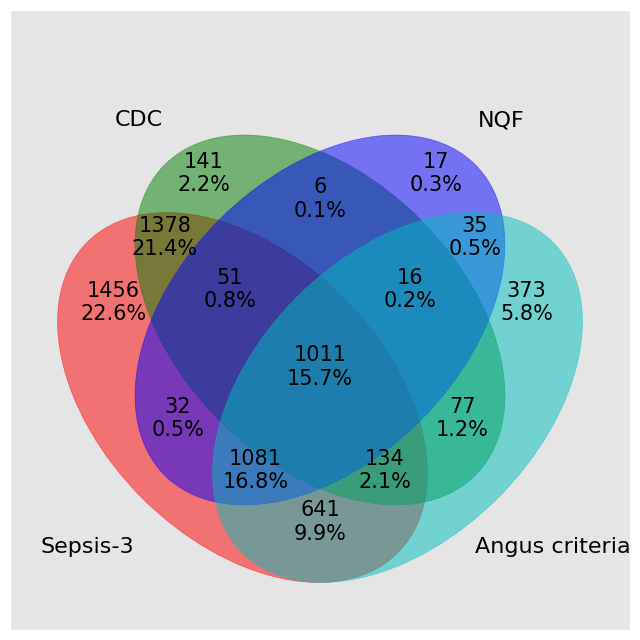

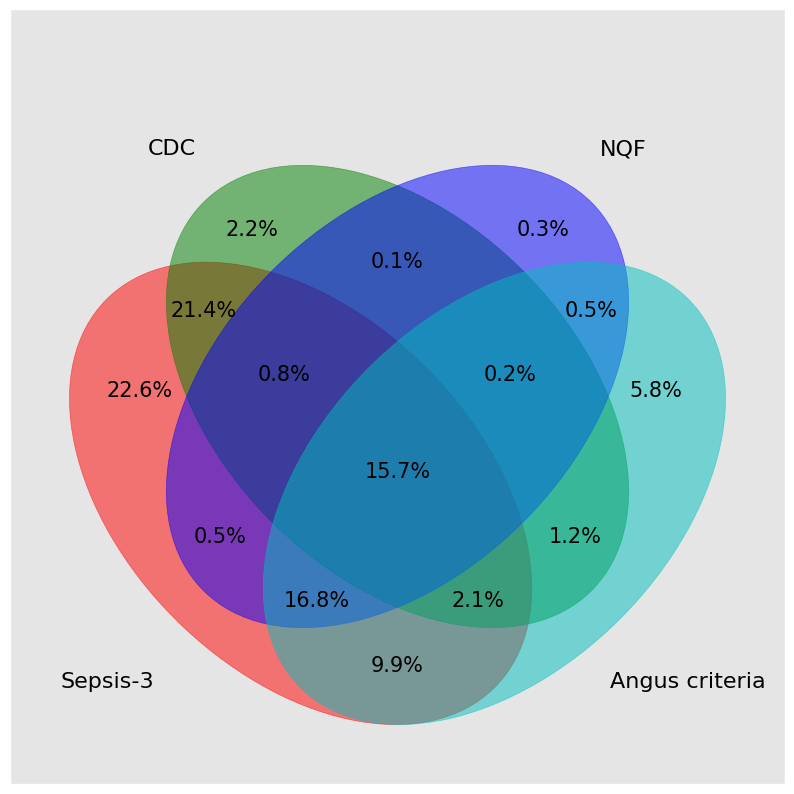

1011 patients (8.6%) satisfied all criteria.
5342 patients (45.3%) satisfied no criteria.
24.3% (2867) - sepsis_angus & sepsis-3
29.9% (3521) - sepsis_cdc & sepsis-3
18.5% (2185) - sepsis_cdc & sepsis_angus
10.4% (1228) - sepsis_nqf & sepsis-3
10.1% (1196) - sepsis_nqf & sepsis_angus
9.2% (1084) - sepsis_nqf & sepsis_cdc


In [25]:
reload(venn)

venn_labels = OrderedDict([
        ['sepsis-3', 'Sepsis-3'],
        ['sepsis_angus', 'Angus criteria'],
        ['sepsis_cdc', 'CDC'],
        ['sepsis_nqf', 'NQF']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

fontdict = {'fontsize': 15, 'fontweight': 'normal'}
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent', figsize=[8,8])
leg = plt.legend('off')
leg.remove()
plt.show()

# also with just percent
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent_only')
leg = plt.legend('off')
leg.remove()
plt.show()

print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set(df['icustay_id'].values).difference(set.union(*sets))),
        len(set(df['icustay_id'].values).difference(set.union(*sets)))*100.0 / df.shape[0]))

# Angus & sepsis-3
for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

# Venn diagram with mortality

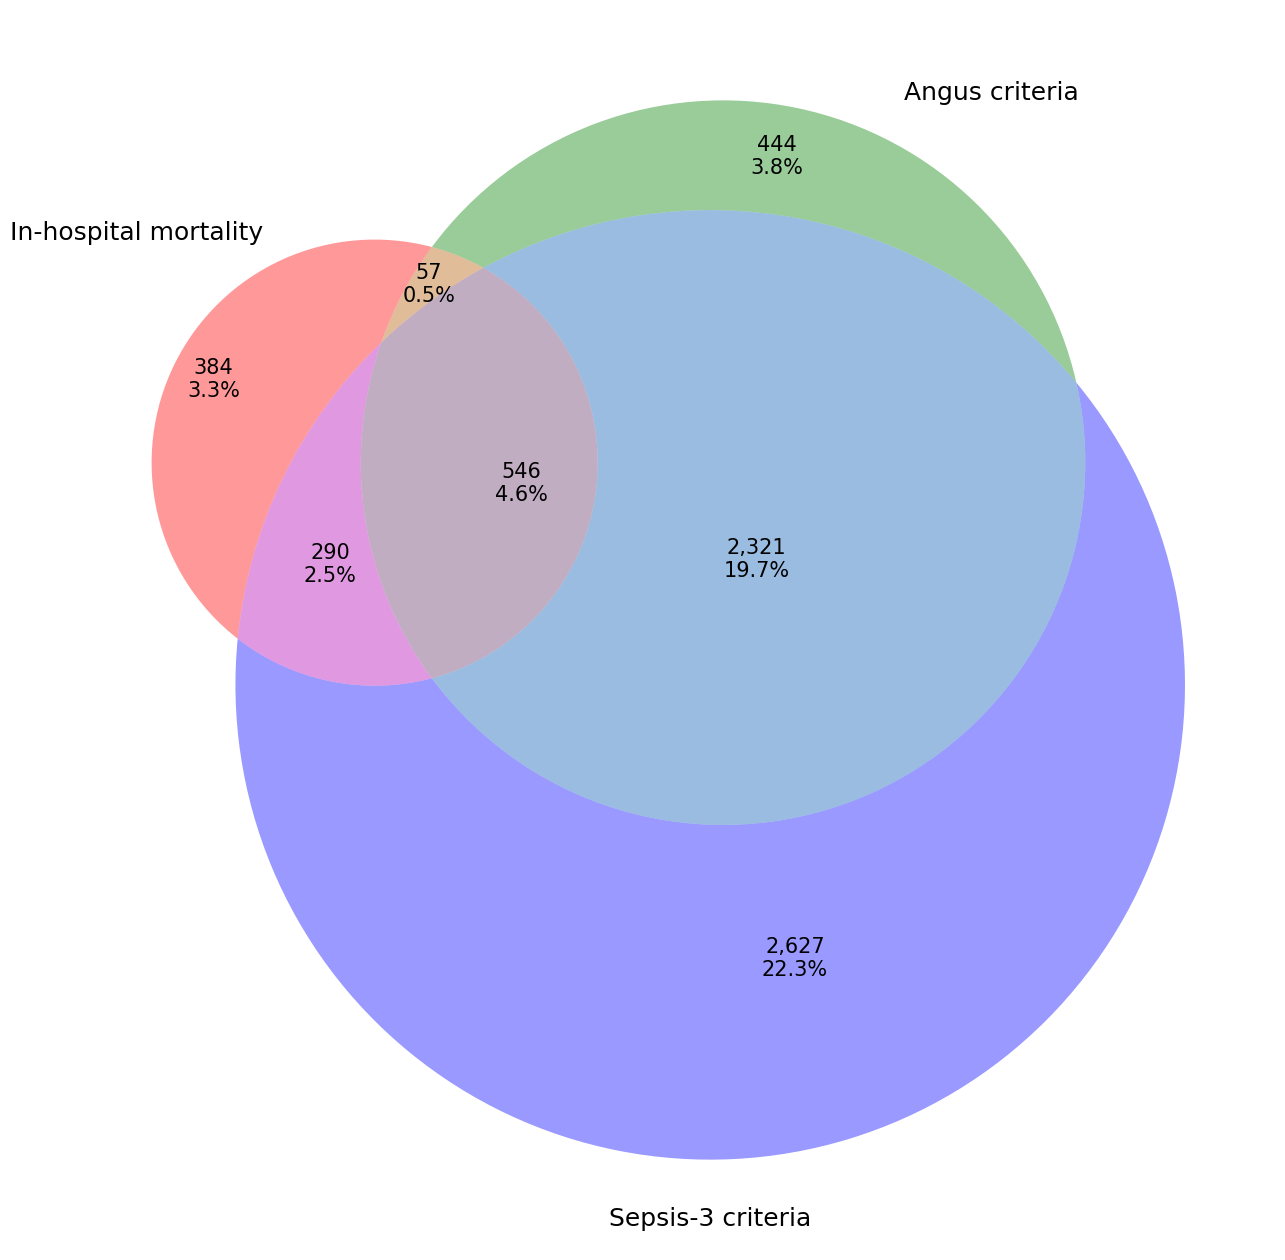

546 patients (4.6%) satisfied all criteria.
5122 patients (43.4%) satisfied no criteria.
5.1% (603) - sepsis_angus & hospital_expire_flag
7.1% (836) - sepsis-3 & hospital_expire_flag
24.3% (2867) - sepsis-3 & sepsis_angus


In [26]:
venn_labels = OrderedDict([
        ['hospital_expire_flag', 'In-hospital mortality'],
        ['sepsis_angus', 'Angus criteria'],
        ['sepsis-3', 'Sepsis-3 criteria']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

set_other = set(df['icustay_id'].values).difference(*sets)

plt.figure(figsize=[16,16])
plt.rcParams.update({'font.size': 15})
venn3(sets, set_names,
      subset_label_formatter=lambda x: '{:,}\n{:2.1f}%'.format(x, x*100.0/df.shape[0]))
plt.savefig('sepsis3-venn-blood-culture.png')
plt.show()

set_other = set(df['icustay_id'].values).difference(*sets)
# Other numbers for above venn diagram
print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set_other),
        len(set_other)*100.0 / df.shape[0]))

for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both), c1, c2))

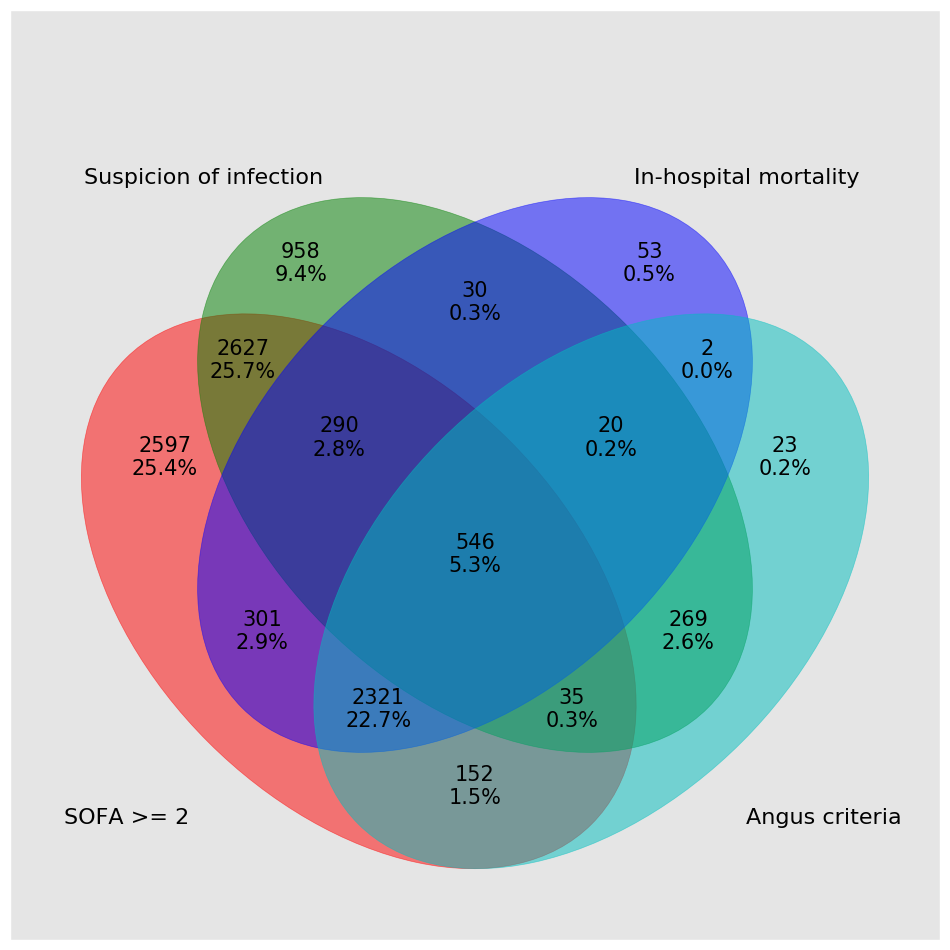

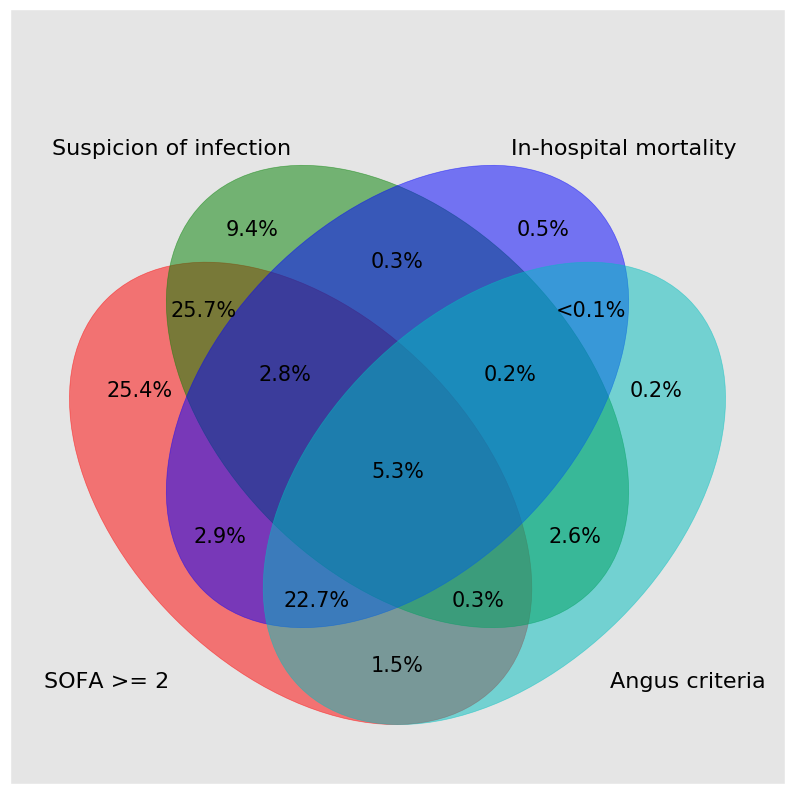

546 patients (4.6%) satisfied all criteria.
1567 patients (13.3%) satisfied no criteria.
25.9% (3054) - sepsis_angus & sofa>=2
49.1% (5784) - suspicion_poe & sofa>=2
26.8% (3156) - suspicion_poe & sepsis_angus
9.9% (1172) - hospital_expire_flag & sofa>=2
5.1% (603) - hospital_expire_flag & sepsis_angus
7.5% (886) - hospital_expire_flag & suspicion_poe


In [27]:
reload(venn)

venn_labels = OrderedDict([
        ['sofa>=2', 'SOFA >= 2'],
        ['sepsis_angus', 'Angus criteria'],
        ['suspicion_poe', 'Suspicion of infection'],
        ['hospital_expire_flag', 'In-hospital mortality']
    ])

sets = list()
set_names = list()
for c in venn_labels:
    idx = df[c]==1
    sets.append(set(df.loc[idx,'icustay_id']))
    set_names.append(venn_labels[c])

fontdict = {'fontsize': 15, 'fontweight': 'normal'}
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent', figsize=[12,12])
leg = plt.legend('off')
leg.remove()
plt.show()

# also with just percent
venn.venn4(sets, set_names, show_plot=False, fontdict=fontdict, fill='percent_only')
leg = plt.legend('off')
leg.remove()
plt.show()

print('{} patients ({:2.1f}%) satisfied all criteria.'.format(len(set.intersection(*sets)),
     len(set.intersection(*sets))*100.0 / df.shape[0]))
print('{} patients ({:2.1f}%) satisfied no criteria.'.format(
        len(set(df['icustay_id'].values).difference(set.union(*sets))),
        len(set(df['icustay_id'].values).difference(set.union(*sets)))*100.0 / df.shape[0]))


for i, c1 in enumerate(venn_labels):
    for j, c2 in enumerate(venn_labels):
        if i<=j:
            continue
        else:
            set_both = set.intersection(sets[i],sets[j])
            print('{:2.1f}% ({}) - {} & {}'.format(
                    len(set_both)*100.0 / df.shape[0], len(set_both),c1, c2))

## add in year .. if available

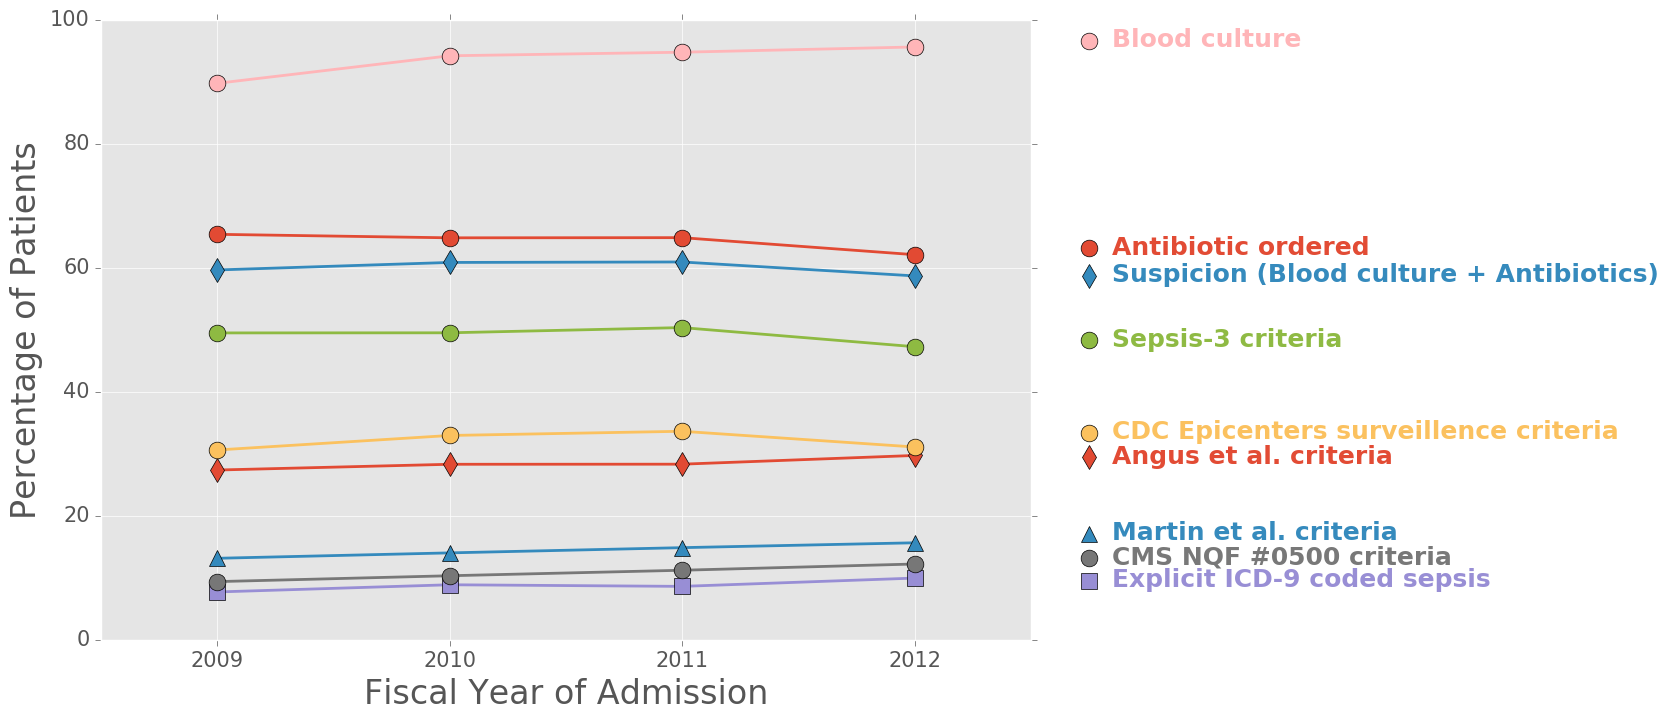

Score          	2009	2010	2011	2012
sepsis_angus   	27.4	28.3	28.3	29.8
sepsis_martin  	13.2	14.0	14.9	15.7
sepsis_explicit	7.7	8.9	8.6	10.0
sepsis_nqf     	9.4	10.4	11.2	12.2
sepsis_cdc     	30.6	33.0	33.7	31.1
sepsis-3       	49.5	49.5	50.4	47.3
blood culture  	89.8	94.2	94.8	95.6
abx_poe        	65.4	64.9	64.9	62.1
suspicion_poe  	59.7	60.9	61.0	58.7


In [28]:
if not os.path.isfile('mimiciii_fiscal_year.csv'):
    print('Cannot create plot as years are not available.')
else:
    yr = pd.read_csv('mimiciii_fiscal_year.csv')
    # set columns to lower case
    yr.columns = [x.lower() if x != 'FISCALYEAR' else 'year' for x in yr.columns]
    
    yr = yr.merge(df, how='inner', left_on='hadm_id', right_on='hadm_id')
    
    #yr_keep = np.lin
    yr_keep = np.linspace(2009,2012,4)
    # create a dataframe that indicates if a patient has:
    # heart rate, blood pressure, temperature, respiration rate
    # in the first day.

    sepsis = ['sepsis_angus','sepsis_martin','sepsis_explicit',
              'sepsis_nqf','sepsis_cdc',
              'sepsis-3',
              #'septic_shock_explicit', 'severe_sepsis_explicit', 'suspicion_mv',
              'blood culture', 'abx_poe', 'suspicion_poe']


    grouped = yr.loc[np.in1d(yr['year'],yr_keep),:].groupby('year')

    plt.figure(figsize=[12,8])

    # get the x-axis from the original data - right now it's plotting against 0:NUMBER_OF_YEARS
    year = np.unique(yr['year'].values)
    Y = year.size

    # set x-axis labels to years
    #ax.set_xticks(range(Y))
    #ax.set_xticklabels(year,fontsize=14)

    pretty_labels = {'sepsis_angus': 'Angus et al. criteria',
                    'sepsis_martin': 'Martin et al. criteria',
                    'sepsis_explicit': 'Explicit ICD-9 coded sepsis',
                    'sepsis_nqf': 'CMS NQF #0500 criteria',
                    'sepsis_cdc': 'CDC Epicenters surveillence criteria',
                    'septic_shock_explicit': 'ICD-9 code 785.52 (septic shock)',
                    'severe_sepsis_explicit': 'ICD-9 code 995.92 (severe sepsis)',
                    'sofa>=2': 'SOFA >= 2',
                    'sepsis-3': 'Sepsis-3 criteria',
                    'blood culture': 'Blood culture',
                    'abx_poe': 'Antibiotic ordered',
                    'suspicion_mv': 'Blood culture + Antibiotics (IV)',
                    'suspicion_poe': 'Suspicion (Blood culture + Antibiotics)',
                    'suspicion_piv': 'Blood culture + Antibiotics (POE IV)'}
    
    # if listed here, we use a special marker
    # otherwise we just use 'o'
    marker_special = {'severe_sepsis_explicit': '^',
                      'sepsis_martin': '^',
                      'sepsis_explicit': 's',
                      'sepsis_angus': 'd',
                      'suspicion_poe': 'd'
                     }
    
    # prevent overlapping labels by changing the y_pos
    y_pos_fix = {'suspicion_poe': -1,
                'sepsis_martin': 0.4,
                'sepsis_explicit': -1.5,
                'sepsis_cdc': 1.3,
                'sepsis_angus': -1.3}
    # ===================== #
    # === PLOT THE DATA === #
    # ===================== #  
    for i, s in enumerate(sepsis):
        marker='o'
        if s in marker_special:
            marker=marker_special[s]
        p = plt.plot(grouped.apply(lambda subf: subf[s].mean()*100.0), label=pretty_labels[s],
                linewidth=2,linestyle='-',marker=marker,markersize=12)


        # Add a text label to the right end of every line
        y_pos = yr.loc[ yr['year'] == yr_keep[-1],s ].mean()*100.0
        x_pos = 2012.85
        
        if s in y_pos_fix:
            y_pos = y_pos + y_pos_fix[s]
            
        # plot the symbol
        plt.plot(x_pos-0.1, y_pos+1.0, linestyle='',
                 color=p[0].get_color(), clip_on=False,
                 marker=marker, markersize=12)
        plt.text(x_pos, y_pos, pretty_labels[s],
                 fontsize=18, fontweight='bold', color=p[0].get_color())    


    # pretty the plot
    plt.ylabel('Percentage of Patients', fontsize=24)
    #plt.legend(loc=[0.6,0.45])
    plt.xticks(yr_keep, ['{:g}'.format(x) for x in yr_keep])
    plt.ylim([0,100])
    plt.xlim([yr_keep[0]-.5,yr_keep[-1]+.5])
    plt.xlabel('Fiscal Year of Admission', fontsize=24)
    plt.savefig('SepsisOverTime.png')
    
    plt.show()
    # print table
    print('{:15s}'.format('Score'),end='')
    for i, y in enumerate(yr_keep):
        print('\t{:g}'.format(y),end='')
    print('')
    
    for i, s in enumerate(sepsis):
        print('{:15s}'.format(s),end='')
        for y in yr_keep:
                print('\t{:2.1f}'.format( np.sum(yr.loc[yr['year']==y,s])*100.0/np.sum(yr['year']==y)),end='')
        print('')

In [29]:
plt.xticks?

# Mortality rates for each group

In [30]:
target_header = "hospital_expire_flag"
idx = df[target_header]==1

# make a confusion matrix with multiple scores in each square
scores = ['sepsis_angus','sepsis_martin','sepsis_explicit','suspicion_poe','sepsis-3','sofa>=2']

print('{:15s} {:15s} {:15s}'.format('0','dead','alive','outcome %'))

for c in scores:
    print('{:15s} {:4d} {:1.1f}%\t{:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]!=1)&idx ),  np.sum( (df[c]!=1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&~idx ), np.sum( (df[c]!=1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&idx )*100.0/np.sum(df[c]!=1)
        ))
print()
print('1')
for c in scores:
    print('{:15s} {:4d} {:1.1f}%\t{:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]==1)&idx ),  np.sum( (df[c]==1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&~idx ), np.sum( (df[c]==1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0/np.sum(df[c]==1)
        ))

0               dead            alive          
sepsis_angus     674 5.7%	 7749 65.7%  8.0%
sepsis_martin    883 7.5%	 9174 77.8%  8.8%
sepsis_explicit  957 8.1%	 9772 82.9%  8.9%
suspicion_poe    391 3.3%	 4339 36.8%  8.3%
sepsis-3         441 3.7%	 5566 47.2%  7.3%
sofa>=2          105 0.9%	 2817 23.9%  3.6%

1
sepsis_angus     603 5.1%	 2765 23.5%  17.9%
sepsis_martin    394 3.3%	 1340 11.4%  22.7%
sepsis_explicit  320 2.7%	  742 6.3%  30.1%
suspicion_poe    886 7.5%	 6175 52.4%  12.5%
sepsis-3         836 7.1%	 4948 42.0%  14.5%
sofa>=2         1172 9.9%	 7697 65.3%  13.2%


# Composite outcome for each group

In [31]:
target_header = "composite_outcome"
idx = (df['hospital_expire_flag']==1) | (df['icu_los']>=3)

# make a confusion matrix with multiple scores in each square
scores = ['sepsis_angus','sepsis_martin','sepsis_explicit','suspicion_poe','sepsis-3','sofa>=2']


print('{:15s} {:12s} {:15s}'.format('0','dead/hi-LOS','alive/lo-LOS','outcome %'))

for c in scores:
    print('{:15s} {:4d} {:1.1f}%   {:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]!=1)&idx ),  np.sum( (df[c]!=1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&~idx ), np.sum( (df[c]!=1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]!=1)&idx )*100.0/np.sum(df[c]!=1)
        ))
print()
print('1')
for c in scores:
    print('{:15s} {:4d} {:1.1f}%   {:5d} {:1.1f}%  {:1.1f}%'.format(
            c,
            np.sum( (df[c]==1)&idx ),  np.sum( (df[c]==1)&idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&~idx ), np.sum( (df[c]==1)&~idx )*100.0/df.shape[0],
            np.sum( (df[c]==1)&idx )*100.0/np.sum(df[c]==1)
        ))

0               dead/hi-LOS  alive/lo-LOS   
sepsis_angus    2150 18.2%    6273 53.2%  25.5%
sepsis_martin   3169 26.9%    6888 58.4%  31.5%
sepsis_explicit 3460 29.3%    7269 61.6%  32.2%
suspicion_poe    939 8.0%    3791 32.2%  19.9%
sepsis-3        1317 11.2%    4690 39.8%  21.9%
sofa>=2          561 4.8%    2361 20.0%  19.2%

1
sepsis_angus    2061 17.5%    1307 11.1%  61.2%
sepsis_martin   1042 8.8%     692 5.9%  60.1%
sepsis_explicit  751 6.4%     311 2.6%  70.7%
suspicion_poe   3272 27.7%    3789 32.1%  46.3%
sepsis-3        2894 24.5%    2890 24.5%  50.0%
sofa>=2         3650 31.0%    5219 44.3%  41.2%


# Mortality: operating point statistics

In [32]:
target_header = "hospital_expire_flag"

# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_dict = OrderedDict([['SOFA', df.sofa.values >= 2],
                        ['SIRS', df.sirs.values >= 2],
                        ['qSOFA', df.qsofa.values >= 2]])

stats_all = su.get_op_stats(yhat_dict, df[target_header].values)

su.print_op_stats(stats_all)

Metric

     	SOFA    	SIRS    	qSOFA   
TN   	 2817		 1536		 4031
FP   	 7697		 8978		 6483
FN   	  105		   66		  263
TP   	 1172		 1211		 1014
Sens 	92 [90, 93]	95 [93, 96]	79 [77, 82]
Spec 	27 [26, 28]	15 [14, 15]	38 [37, 39]
PPV  	13 [13, 14]	12 [11, 13]	14 [13, 14]
NPV  	96 [96, 97]	96 [95, 97]	94 [93, 95]
F1   	 23.10   	 21.12   	 23.11   
NTP  	 9.94   	 10.27   	 8.60   
NFP  	 65.28   	 76.14   	 54.98   


# Composite outcome: operating point statistics

In [33]:
target_header = "composite_outcome"

# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_dict = OrderedDict([['SOFA', df.sofa.values >= 2],
                        ['SIRS', df.sirs.values >= 2],
                        ['qSOFA', df.qsofa.values >= 2]])

stats_all = su.get_op_stats(yhat_dict, df[target_header].values)

su.print_op_stats(stats_all)

Metric

     	SOFA    	SIRS    	qSOFA   
TN   	 2361		 1302		 3236
FP   	 5219		 6278		 4344
FN   	  561		  300		 1058
TP   	 3650		 3911		 3153
Sens 	87 [86, 88]	93 [92, 94]	75 [74, 76]
Spec 	31 [30, 32]	17 [16, 18]	43 [42, 44]
PPV  	41 [40, 42]	38 [37, 39]	42 [41, 43]
NPV  	81 [79, 82]	81 [79, 83]	75 [74, 77]
F1   	 55.81   	 54.32   	 53.86   
NTP  	 30.96   	 33.17   	 26.74   
NFP  	 44.26   	 53.24   	 36.84   


## Cronbach alpha and Kuder-Richardson Formula 20 agreement

In [34]:
np.random.seed(21381)
# cronbach alpha for construct validity
reload(su)
print(' === Cronbach Alpha ===')
su.cronbach_alpha_table(df, ['sepsis_angus','sepsis_martin', 'sepsis_explicit','sepsis-3'])

print('')
print(' === KR20 ===')
su.kr20_table(df, ['sepsis_angus','sepsis_martin', 'sepsis_explicit','sepsis-3'])

print('Cronbach alpha is a generalization of KR20 to ordinal items.')

 === Cronbach Alpha ===
          	martin    	explicit  	sepsis-3  	
angus     	0.69 [0.68-0.70] 0.62 [0.61-0.63] 0.62 [0.61-0.64] 
martin    	          	0.85 [0.84-0.86] 0.49 [0.48-0.50] 
explicit  	          	          	0.40 [0.38-0.41] 
sepsis-3  	          	          	          	

 === KR20 ===
          	sepsis_angus        	sepsis_martin       	sepsis_explicit     	sepsis-3            	
sepsis_angus	                    	0.692 [0.679, 0.705]	0.621 [0.609, 0.634]	0.624 [0.613, 0.635]	
sepsis_martin	                    	                    	0.846 [0.836, 0.856]	0.493 [0.483, 0.506]	
sepsis_explicit	                    	                    	                    	0.399 [0.386, 0.411]	
sepsis-3  	                    	                    	                    	                    	
Cronbach alpha is a generalization of KR20 to ordinal items.


# Severity of illness stats

In [35]:
print('{:5g} ({:3.1f}%) first ICU stay for adults.'.format(
        df['icustay_id'].count(), 100))
for c in ['sirs','qsofa','sofa','sepsis-3',
          'sepsis_angus','sepsis_martin','sepsis_explicit']:
    if df[c].max() == 1:
        print('{:5g} ({:3.1f}%)  with {}'.format(
                (df[c]==1).sum(),
                (df[c]==1).sum()*100.0/df.shape[0], c))
    else:
        print('{:5g} ({:3.1f}%)  with {} >= 2'.format(
                (df[c]>=2).sum(),
                (df[c]>=2).sum()*100.0/df.shape[0], c))

11791 (100.0%) first ICU stay for adults.
10189 (86.4%)  with sirs >= 2
 7497 (63.6%)  with qsofa >= 2
 8869 (75.2%)  with sofa >= 2
 5784 (49.1%)  with sepsis-3
 3368 (28.6%)  with sepsis_angus
 1734 (14.7%)  with sepsis_martin
 1062 (9.0%)  with sepsis_explicit


## AUROC of severity of illness scores

In [ ]:
"""
# ensure bootstrap always results in the same confidence intervals
np.random.seed(978236412)

# define outcome
target_header = "hospital_expire_flag"

# define the covariates to be added in the model (used for table of AUROCs)
preds_header = ['sirs','qsofa','sofa']
preds = su.calc_predictions(df, preds_header, target_header, model=None)

print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')
"""

# Mortality: build models with different covariates

In [ ]:
# define outcome
target_header = "hospital_expire_flag"

# define the covariates to be added in the model (used for table of AUROCs)
preds_header = ['sirs','qsofa','qsofa_norx','sofa']
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_logreg = su.calc_predictions(df, preds_header, target_header, model='logreg')


print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using logistic regression):')
su.print_auc_table(preds_logreg, df[target_header].values, preds_header)
print('\n')

In [ ]:
from statsmodels.formula.api import logit
target_header = "hospital_expire_flag"
pred_header = 'sofa'
# test model on its own
auc = ru.calc_auc(df[pred_header].values, df[target_header].values, with_ci=False)
print('{} - univariable'.format(pred_header))
print('AUROC={:0.3f}'.format(auc))



# test model performance with addition of lactate
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

# test model performance with age and comorbid burden
formula  = target_header + " ~ age + elixhauser_hospital"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())


# test model performance with all above covariates
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ age + elixhauser_hospital + lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

# Composite outcome - prediction performance

In [ ]:
# define outcome
target_header = 'composite_outcome'

# define the covariates to be added in the model (used for table of AUROCs)
preds_header = ['sirs','qsofa','qsofa_norx', 'sofa']
preds = su.calc_predictions(df, preds_header, target_header, model=None)
preds_logreg = su.calc_predictions(df, preds_header, target_header, model='logreg')


print('AUROC table for unadjusted scores:')
su.print_auc_table(preds, df[target_header].values, preds_header)
print('\n')

print('AUROC table for adjusted scores (using logistic regression):')
su.print_auc_table(preds_logreg, df[target_header].values, preds_header)
print('\n')

In [ ]:
from statsmodels.formula.api import logit
target_header = 'composite_outcome'
pred_header = 'sofa'
# test model on its own
auc = ru.calc_auc(df[pred_header].values, df[target_header].values, with_ci=False)
print('{} - univariable'.format(pred_header))
print('AUROC={:0.3f}'.format(auc))




# test model performance with addition of lactate
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

# test model performance with age and comorbid burden
formula  = target_header + " ~ age + elixhauser_hospital"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())


# test model performance with all above covariates
df['lactate_max_imputed'] = df['lactate_max']
df['lactate_max_imputed'].fillna(value=0, inplace=True)
formula = target_header + " ~ age + elixhauser_hospital + lactate_missing + lactate_max_imputed"
formula += " + " + pred_header
print('{}'.format(formula))
model = logit(formula=formula,data=df).fit(disp=0)
auc, ci = ru.calc_auc(model.predict(), df[target_header].values, with_ci=True, alpha=0.05)

print('AUROC={:0.3f} [{:0.3f} - {:0.3f}]'.format(auc,ci[0],ci[1]))
print(model.summary2())

In [ ]:
print('Odds ratios for final model w/ lactate')
for p in model.params.index:
    print('{:20s} {:1.2f}'.format(p, np.exp(model.params[p])))

## Lactate groups

In [ ]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='hospital_expire_flag')


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa_composite, lbl_sofa_composite = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='composite_outcome')

plt.figure(figsize=[10,6])
xi = np.linspace(0,7,8)
plt.bar(xi+0.1,x_sofa,facecolor='b', label='SOFA',width=0.4)
plt.bar(xi+0.5,x_sofa_composite,facecolor='r',alpha=0.5,label='SOFA composite',width=0.4)
plt.xticks(np.linspace(0,7,8)+0.3, [x.replace('SOFA','').replace('No lactate','N/A') for x in lbl_sofa])
plt.legend(loc='upper left')
plt.ylabel("Hospital mortality / composite")
plt.text(7.8,-0.09,'Lactate\nSOFA')
plt.show()

In [ ]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='hospital_expire_flag')


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa_composite, lbl_sofa_composite = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd, targetStr='composite_outcome')

print('{:10s}\tSOFA< 2\tSOFA>=2'.format(''),end='')
print('\t\tSOFA< 2\tSOFA>=2'.format(''))
for i in range(len(lbl_sofa)/2):
    i1 = 2*i
    i2 = 2*i+1
    
    print('{:10s}\t{:2.1f}\t{:2.1f}'.format( lbl_sofa[i1].split('\n')[0], 100.0*x_sofa[i1], 100.0*x_sofa[i2] ), end='')
    print('\t\t{:2.1f}\t{:2.1f}'.format( 100.0*x_sofa_composite[i1], 100.0*x_sofa_composite[i2] ))